In [8]:
################################################################################
# SETUP
################################################################################

# Convenience and saving flags
ABRIDGED_RUN = True # Set to True to train and validate on less epochs, for quick funcitonality tests etc
SAVE_AFTER_TRAINING = True # Save the model when you are done
SAVE_CHECKPOINTS = True # Save the model after every epoch
REPORT_TRAINING_LOSS_PER_EPOCH = True # Track the training loss each epoch, and write it to a file after training
REPORT_VALIDATION_LOSS_PER_EPOCH = True # Lets us make a nice learning curve after training

# Training hyperparameters
BATCH_SIZE = 16 # Number of samples per batch while training our network
NUM_EPOCHS = 25000 # Number of epochs to train our network
if ABRIDGED_RUN == True:
    NUM_EPOCHS = 1001
    
LEARNING_RATE = 1e-5 # Learning rate for our optimizer

# Directories
CHECKPOINT_DIR = "checkpoints/" # Checkpoints, models, and training data will be saved here
MODEL_NAME = None

In [9]:
################################################################################
# IMPORTS
################################################################################

print("Importing modules")

# Basic imports
import pandas as pd
import numpy as np
np.random.seed(1234)
import time
import scipy.io
from scipy.stats import qmc
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
from pathlib import Path

# Torch imports
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
print("Import complete")


device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"{device} enabled")

Importing modules
Import complete
mps enabled


## Test Case for PINN: 2D Poisson

We consider the equation $$u_{xx} + u_{yy} = f$$
where $$f(x, y) = -8\pi^2 \sin(2\pi x) \sin(2\pi y), \; (x,y) \in \Omega, \quad \Omega = [0,1] \times [0,1].$$

We impose the following boundary conditions.
1. Homogeneous Dirichlet BC on the bottom: $$u(x, 0) = 0, \; x \in [0,1].$$
2. Periodic BC on the sides: $$u(0, y) = u(1, y), \; y \in [0,1]$$
3. Neumann BC on the top: $$\frac{\partial u}{\partial n}(x, 1) = 2\pi \sin(2\pi x), \; x \in [0,1].$$

Explicit solution that we are aiming to approximate: $$u(x, y) = \sin(2\pi x) \sin(2\pi y), \; (x,y) \in \Omega.$$

(-0.05, 1.05, -0.05, 1.05)

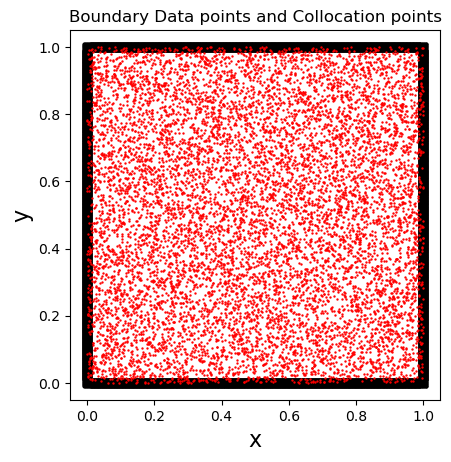

In [10]:
################################################################################
# DOMAIN INITIALIZATION
################################################################################

layers = np.array([2, 128, 256, 256, 256, 256, 256,256, 128, 1])

x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x = 1000
total_points_y = 1000

N_boundary = 4 # number of boundaries
N_u_boundary = 2500 # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = 10000 # number of collocation points

#Boundary condition weights in loss function 
w_bc_top = 5
w_bc_bottom = 1
w_bc_lr = 1

engine = qmc.LatinHypercube(d=1)

boundary_top = engine.random(n = N_u_boundary)
boundary_lr = engine.random(n = N_u_boundary)
boundary_bot = engine.random(n = N_u_boundary)

data = np.zeros([N_boundary, N_u_boundary, 2])

data[0, :, 0] = boundary_top[:, 0]
data[1, :, 1] = boundary_lr[:, 0]
data[2, :, 1] = boundary_lr[:, 0]
data[3, :, 0] = boundary_bot[:, 0]

data[0, :, 1] = np.ones(N_u_boundary) # y = 1
data[1, :, 0] = np.zeros(N_u_boundary) # x = 0
data[2, :, 0] = np.ones(N_u_boundary) # x = 1
data[3, :, 1] = np.zeros(N_u_boundary) # y = 0

data = data.reshape(-1, 2)
x_d, y_d = data[:, 0:1], data[:, 1:2]

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n = N_f)

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
#plt.show()


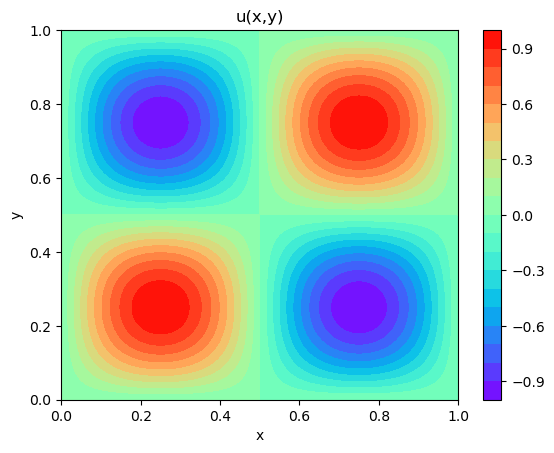

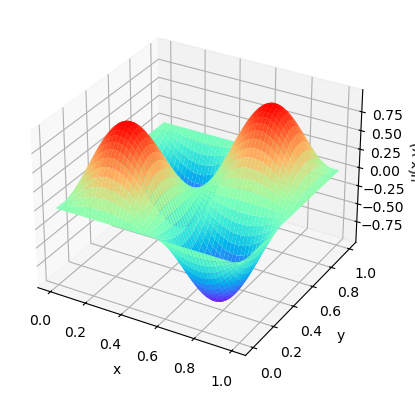

In [11]:
#Plotting explicit solution
def u_sol(x, y):
    return torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)
U_sol = u_sol(X, Y)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, U_sol ,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('u(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), U_sol.numpy(),cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
plt.show()

In [12]:
class PINN(nn.Module):

    def __init__(self, layers):
        super().__init__()
        
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
        
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        
        a = torch.cat((x.float(), y.float()), axis=1)

        
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    # Neumann BC on top
    def loss_BC_top(self, x):
        x_clone = x.clone().requires_grad_(True)
        y = torch.ones_like(x_clone).requires_grad_(True)
        
        u = self.forward(x_clone, y)
        u_y = autograd.grad(u.sum(), y, create_graph=True)[0]
        
        return self.loss_function(u_y, 2 * np.pi * torch.sin(2 * np.pi * x_clone))
    
    # Periodic BC on left/right
    def loss_BC_lr(self, y):
        u_l = self.forward(torch.zeros_like(y), y)
        u_r = self.forward(torch.ones_like(y), y)
        
        return self.loss_function(u_l, u_r)
    
    # Dirichlet BC on bottom
    def loss_BC_bot(self, x):
        return self.loss_function(self.forward(x, torch.zeros_like(x)), torch.zeros_like(x))
    
    def loss_PDE(self, x, y):
        x_clone = x.clone().requires_grad_(True)
        y_clone = y.clone().requires_grad_(True)
        
        u = self.forward(x_clone, y_clone)
        u_x = autograd.grad(u.sum(), x_clone, create_graph=True)[0]
        u_y = autograd.grad(u.sum(), y_clone, create_graph=True)[0]
        u_xx = autograd.grad(u_x.sum(), x_clone, create_graph=True)[0]
        u_yy = autograd.grad(u_y.sum(), y_clone, create_graph=True)[0]

        f = u_xx + u_yy
        return self.loss_function(f + 8 * np.pi**2 * torch.sin(2 * np.pi * x_clone) * torch.sin(2 * np.pi * y_clone), torch.zeros_like(f))
    
    def loss (self, x_top, x_bot, y_lr, x_PDE, y_PDE):
        return w_bc_bottom * self.loss_BC_bot(x_bot) + w_bc_lr * self.loss_BC_lr(y_lr) + w_bc_top * self.loss_BC_top(x_top) + self.loss_PDE(x_PDE, y_PDE)

In [13]:
x_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
u_test = U_sol.transpose(1, 0).flatten()[:, None]

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

train_bd_top = torch.tensor(boundary_top).float().to(device)
train_bd_lr = torch.tensor(boundary_lr).float().to(device)
train_bd_bot = torch.tensor(boundary_bot).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)

In [14]:
################################################################################
# TRAINING SETUP
################################################################################

# Create a saving directory if needed
output_dir = Path(f'{CHECKPOINT_DIR}{MODEL_NAME}')
output_dir.mkdir(parents=True, exist_ok=True)
output_dir = f'{CHECKPOINT_DIR}{MODEL_NAME}'

# Instantiate our model
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)


start_time = time.time()

training_losses = [None]*NUM_EPOCHS
validation_losses = [None]*NUM_EPOCHS

#Turn on the gradient

torch.enable_grad() 

for epoch in tqdm(range(NUM_EPOCHS), leave = False):
    
    optimizer.zero_grad()
    loss = model.loss(train_bd_top, train_bd_bot, train_bd_lr, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        # Save checkpoint
        if SAVE_CHECKPOINTS == True:
            torch.save(model.state_dict(), f"{CHECKPOINT_DIR}{MODEL_NAME}/checkpoint_{epoch}.pt")

        # Compute training loss
        if REPORT_TRAINING_LOSS_PER_EPOCH == True:    
            training_losses[epoch] = loss.item()
        
        if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
            model.eval()
            torch.no_grad()
            validation_loss = model.loss_function(model(x_test[:, 0:1], x_test[:, 1:2]), u_sol(x_test[:, 0:1], x_test[:, 1:2]))
            validation_losses[epoch] = validation_loss.cpu().item()
            model.train()
            torch.enable_grad()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss.item()}, Validation loss {validation_loss.item()}')
        
        losses = pd.DataFrame({"training_losses":training_losses, "validation_losses":validation_losses})
        cols = []
        
        if REPORT_TRAINING_LOSS_PER_EPOCH == True:
            cols += ["training_losses"]
            
        if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
            cols += ["validation_losses"]
            
        if len(cols) > 0:
            losses[cols].to_csv(f'{output_dir}/losses.csv', index = False)
        
end_time = time.time()

print('Finished Training')

print(f'Training time: {end_time - start_time}s')

  0%|          | 2/1001 [00:03<24:25,  1.47s/it]

Epoch 0, Training loss 1647.524169921875, Validation loss 0.26357343792915344


Epoch 1000, Training loss 82.81309509277344, Validation loss 0.5883774161338806
Finished Training
Training time: 100.0902988910675s


In [15]:
################################################################################
# SAVE AND REPORT 
################################################################################

# Save model
if SAVE_AFTER_TRAINING == True:
    torch.save(model.state_dict(), f'{output_dir}/final.pt')

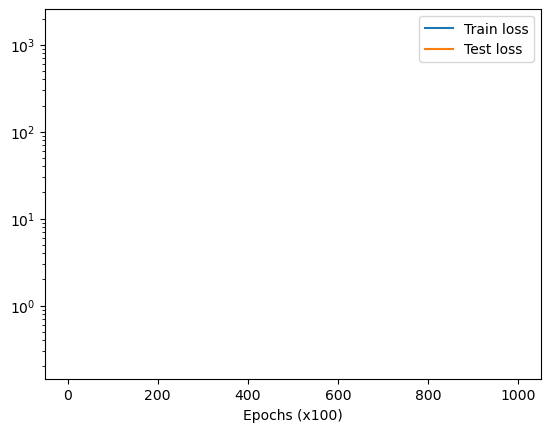

In [16]:
plt.semilogy(training_losses, label='Train loss')
plt.semilogy(validation_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()

Plots!

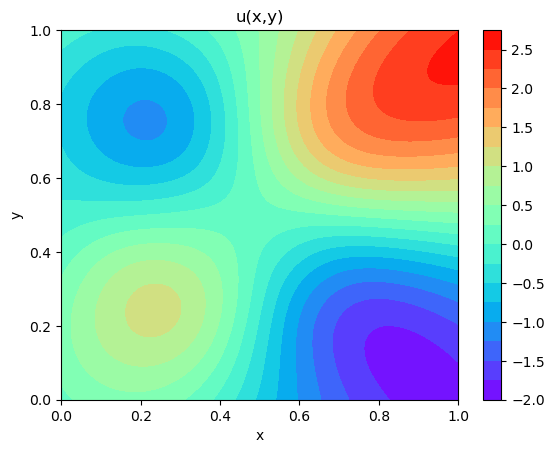

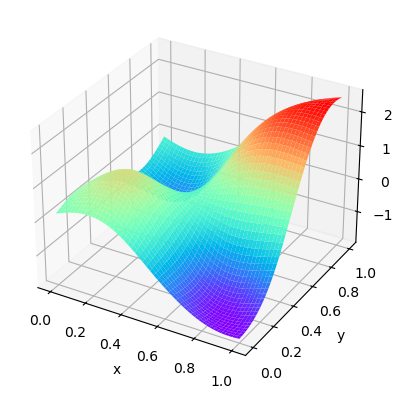

In [17]:
u_pred = model.forward(x_test[:, 0:1], x_test[:, 1:2]).cpu().detach()
u_pred = u_pred.reshape(total_points_x, total_points_y).transpose(1, 0)


fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, u_pred ,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('u(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), u_pred.numpy(),cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
plt.show()

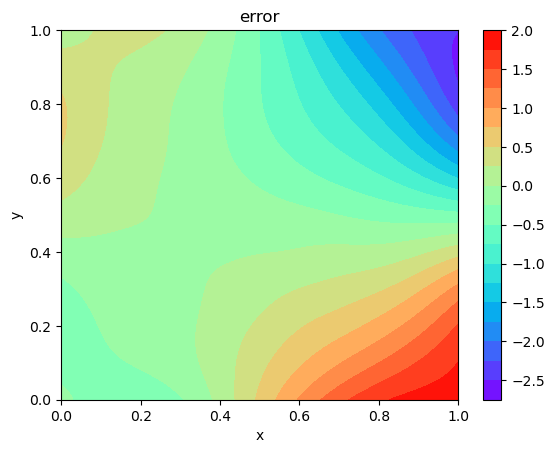

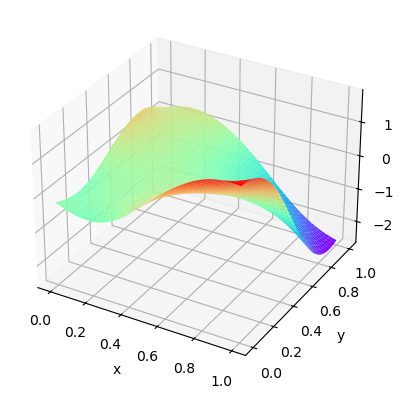

In [18]:
error = u_sol(X, Y) - u_pred

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, error ,20,cmap="rainbow")
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('error')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), error.numpy(),cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('error')
plt.show()